In [1]:
from classes.connectivity_blocks import *
from classes.network_dynamics import *
from classes.task import *
from classes.functions_analysis import *
import torch as tch
import pandas
import scipy.io as sio
import pickle

import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

In [2]:
def model_parameters():
    modelparams = dict(
            seed = 3,#4,
            #network parameters
            n_ctx = 180,
            N_block = 400, #neurons per region
            N_recorded = 200, #neurons recorded per region

            #transfer function Pereira&Brunel,18
            rm = 1,#76.2,
            beta = 1, #Pereira&Brunel
            h0 = .1,
            amp_offset = 1,

            #dynamics excitatory
            tau_ctx =  60 * 1e-3,#s mainly NMDA

            #private noise 
            sigma_noise = 0,

            #Low-d noise
            sigma_ld = 22,
            tau_ld = 100 * 1e-3,
            mu_ld = 0,
            
            #spines dependencies
            A_spines = 1,#10
            offset_spines = .1,
            
            #noise
            amp_loc_noise = 0.1,#0.0, #amp noise local dorsal
            amp_lr_noise = 0.1,#0.0, #ventral<->ventral amp noise long-range

            #hebbian 
            amp_loc = 1.,
            amp_lr = 1.,


            #stimulation parameters
            period = 10., # 20 seconds
            dt = 15. * 1e-3,# indegration time
            t_stim = .5, #period-t_stim when stimulus
            t_start = 2.5, #t_starts
            g_p= 1.5,

            g_sym = 0,
            g_asym = 0,
            g_random = 0,
            grad_NM= np.zeros(180)
            
            )
    return modelparams

In [3]:
def loading_matrices(gamma, path=''):
    ''' this functions load the matrices and normalize them'''
    PATH = path + 'connectivity_data/'
    tract = sio.loadmat(PATH + 'FSe_tractography.mat')
    serotonin =sio.loadmat('connectivity_data/human_data/HTR1A_genevals.mat')
    names_serotonin = sio.loadmat('connectivity_data/human_data/HCP_180_area_names_LH.mat')
    names_ctx = [tract['area_list_Sean_89'][0][l][0] for l in range(89)] 
    #fln = pickle.load(open(PATH + 'mat_tractography.p','rb'))
    con = sio.loadmat(open('connectivity_data/human_data/human_structural_conn.mat', 'rb'))
    matrix = con['lh_struct_conn_rownorm']
    fln = matrix
    t1_t2 =  sio.loadmat('connectivity_data/human_data/myelin_HCP_vec.mat')
    t1_t2_val = t1_t2['myelin_parcels_mean'][:,0]
    t1_t2_val = -(t1_t2_val - np.max(t1_t2_val))/(np.max(t1_t2_val) - np.min(t1_t2_val)) #normalizing
    sln = pickle.load(open(PATH+'sln_matrix.p','rb'))
    #matrices
    fln2 =   fln**gamma
    fln2 = np.einsum('ij,i->ij',fln2, 1/np.sum(fln2,axis =1)) 
    connectivity = dict(
            fln = fln2,
            sln = sln,
            hierarchy_t1t2 = t1_t2_val,
            serotonin = serotonin['genevals'],
            names_serotonin = [s[0][0] for s in names_serotonin['HCP_180_area_names_LH']])           
    return connectivity
areas = pandas.read_csv('connectivity_data/human_data/hcp_regions_cog_networks_overlap.csv')



In [4]:
# importing monkey connectivity
connectivity_params = loading_matrices(0.35)

#model parameters
modelparams = model_parameters()
modelparams['amp_loc_noise'] = 2.#1.4#1.1
modelparams['amp_lr_noise'] = 2.#1.8#1.2
modelparams['amp_loc'] = 1.
modelparams['amp_lr'] = 3.5


#creating connectivity
thres = .3 #0.2
connectivity = CorticalConnectivity(modelparams, connectivity_params)
connectivity.hebbian_symmetric.p_sym = 2
inds = []
DMN = list(np.where(areas['Default']>thres)[0])
DAN = list(np.where(areas['DorsAtt']>thres)[0])
salience = list(np.where(areas['Salience']>thres)[0])
FPN = list(np.where(areas['FPN']>thres)[0])

fpn_dmn = np.zeros((180,180))
fpn_salience_dan_sym = np.zeros((180,180))
fpn_salience_dan_asym = np.zeros((180,180))
for l in range(180):
    for k in range(180):
        if l  in FPN and k in FPN:
            fpn_dmn[l,k] = 2.3
            fpn_salience_dan_sym[l,k] = 1.6
        if l in FPN and k in DMN:
            fpn_dmn[l,k] = 2.3
        if k in FPN and l in DMN:
            fpn_dmn[l,k] = 2.3
        if l in DMN and k in DMN:
            fpn_dmn[l,k] = 2.1#2.3
        if l in DAN and k in FPN:
            fpn_salience_dan_sym[l,k] = 2
        if k in DAN and l in FPN:
            fpn_salience_dan_sym[l,k] = 1.2
        if l in DAN and k in DAN:
            fpn_salience_dan_sym[l,k] = 2.6
        if l in salience and k in salience:
            fpn_salience_dan_asym[l,k] = 2.1
        if l in FPN and k in salience:
            fpn_salience_dan_asym[l,k] = 5

amp_inds = [(fpn_dmn ,0 * fpn_dmn ), (fpn_salience_dan_sym,fpn_salience_dan_asym)] 
fpn_plus_dmn = FPN + DMN
fpn_plus_da = FPN + DAN+ salience
inds.append(fpn_plus_dmn)
inds.append(fpn_plus_da)
connectivity.hebbian_symmetric.update_indexes(inds, amp_inds)

In [5]:
s_stim = 1
#creating network
modelparams['period'] = 10.
modelparams['t_start']=5.#3.5
modelparams['t_stim']= .15
#modelparams['beta'] = 1.9#1.5
#modelparams['h0'] = 1.13#1.1
modelparams['g_p'] = 5.#0
modelparams['beta'] = 2.5#2.5
modelparams['h0'] = 1.13#1.13
t_start = modelparams['t_start']

#input patterns
task = working_memory_task(modelparams, connectivity)
task.ind_stim=np.array(salience)
task.pat_input_asymmetric(ind_pat=1)


network = NetworkDynamics(modelparams, connectivity)
network.overlaps.is_sym = True
network.input_ctx = task.input_current


#running dynamics
s0_ctx =  0 * np.random.uniform(0,.1, network.mat.shape[0])

amp_in = 10000000
ind_pat = 0
for l in inds[0]:
    Nl = l * connectivity.N
    Nlp1 = (l + 1) * connectivity.N
    s0_ctx[Nl : Nlp1] = amp_in * connectivity.hebbian_symmetric.patterns_current_sym[l, :, 0, ind_pat]
results = network.dynamics(s0_ctx)

Simulation t= 0.0
Simulation t= 0.015
Simulation t= 0.03
Simulation t= 0.045
Simulation t= 0.06
Simulation t= 0.075
Simulation t= 0.09
Simulation t= 0.105
Simulation t= 0.12
Simulation t= 0.135
Simulation t= 0.15
Simulation t= 0.165
Simulation t= 0.18
Simulation t= 0.195
Simulation t= 0.21
Simulation t= 0.225
Simulation t= 0.24
Simulation t= 0.255
Simulation t= 0.27
Simulation t= 0.285
Simulation t= 0.3
Simulation t= 0.315
Simulation t= 0.33
Simulation t= 0.345
Simulation t= 0.36
Simulation t= 0.375
Simulation t= 0.39
Simulation t= 0.405
Simulation t= 0.42
Simulation t= 0.435
Simulation t= 0.45
Simulation t= 0.465
Simulation t= 0.48
Simulation t= 0.495
Simulation t= 0.51
Simulation t= 0.525
Simulation t= 0.54
Simulation t= 0.555
Simulation t= 0.57
Simulation t= 0.585
Simulation t= 0.6
Simulation t= 0.615
Simulation t= 0.63
Simulation t= 0.645
Simulation t= 0.66
Simulation t= 0.675
Simulation t= 0.69
Simulation t= 0.705
Simulation t= 0.72
Simulation t= 0.735
Simulation t= 0.75
Simulatio

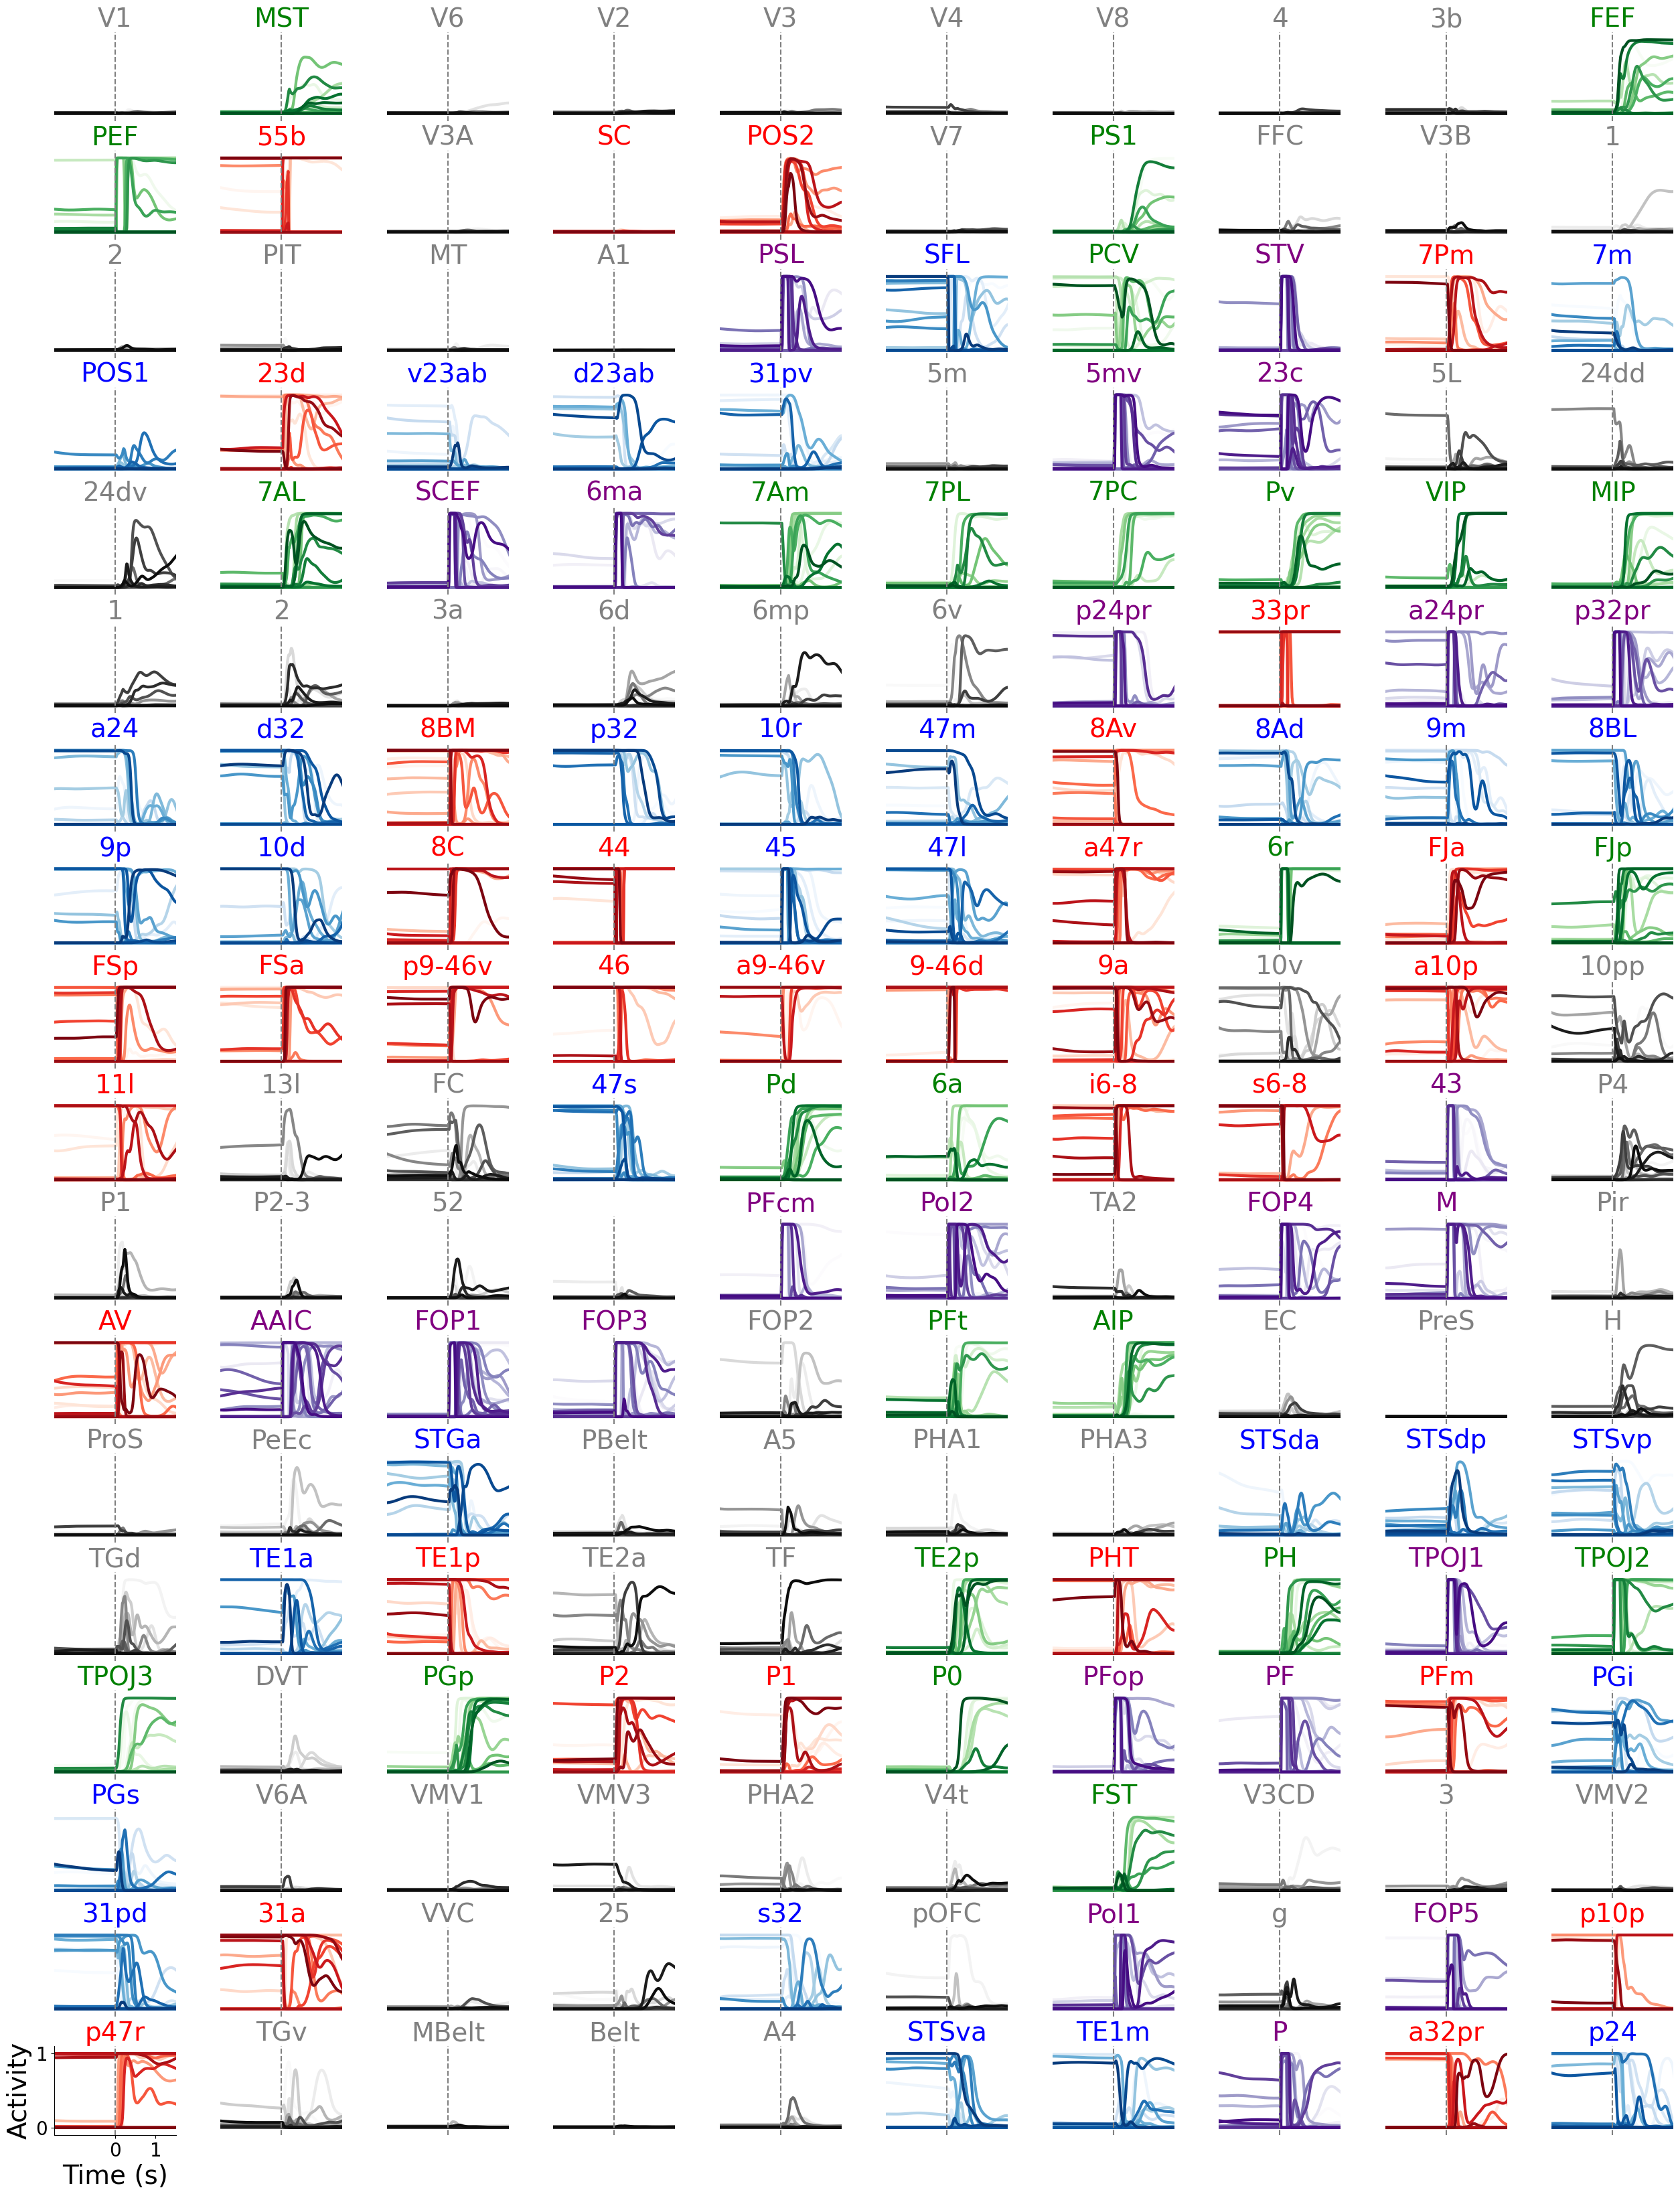

In [7]:
from cycler import cycler

modelparams = model_parameters()

#results = pickle.load(open('data/gradient_chaos/sim_0.011.p', 'rb'))
time = results['time']
r_ctx = results['rates_ctx']

name_grad = 'figures/SI_attractors_rates_fig_6_human.pdf'

s_ticks = 20
fs=28
lw_fr = 3
N_block = modelparams['N_block'] # resolution saved nurons 
N_recorded = modelparams['N_recorded'] # resolution saved nurons 
N_neu =int( N_block/int(N_block/N_recorded)) #number recorded neurons
colors = plt.cm.hsv(np.linspace(0,1, N_neu))
#names_ctx, inds_full = names_inds_ctx()
modelparams['period'] = 10.
modelparams['t_start']=5.#3.5
modelparams['t_stim']= .15
dt = modelparams['dt']
t_start = modelparams['t_start'] 
t_stop = modelparams['period']
t_end = r_ctx.shape[0] * dt


colors_greens = plt.cm.Greens(np.linspace(0,1, N_neu))
colors_blues = plt.cm.Blues(np.linspace(0,1, N_neu))
colors_reds = plt.cm.Reds(np.linspace(0, 1 , N_neu))
colors_greys = plt.cm.Greys(np.linspace(0, 1 , N_neu))
colors_purples = plt.cm.Purples(np.linspace(0, 1 , N_neu))
    
# plotting altoghether 
fig, ax = plt.subplots(figsize=(25, 32),nrows=18, ncols=10)
fig.tight_layout()
l=0
n_row= 0
for row in ax:
    n_col=0
    for col in row:
        time = np.linspace(0, t_end , r_ctx.shape[0])
        if l<=179:
            ind_1 = l * N_neu
            ind_2 = (l+1) * N_neu
            #col.set_prop_cycle(cycler('color', colors))
            if l in FPN:
                color = 'red'
                for k in range(l * N_neu, (l+1)* N_neu, 10):
                    col.plot(time, r_ctx[:, k], lw=lw_fr, color = colors_reds[k - l* N_neu])
            elif l in DAN:
                color = 'green'
                for k in range(l * N_neu, (l+1)* N_neu, 10):
                    col.plot(time, r_ctx[:, k], lw=lw_fr, color = colors_greens[k - l* N_neu])
            elif l in DMN:
                color = 'blue'
                for k in range(l * N_neu, (l+1)* N_neu, 10):
                    col.plot(time, r_ctx[:, k], lw=lw_fr, color = colors_blues[k - l* N_neu])
            elif l in salience:
                color = 'purple'
                for k in range(l * N_neu, (l+1)* N_neu, 10):
                    col.plot(time, r_ctx[:, k], lw=lw_fr, color = colors_purples[k - l* N_neu])
            else:
                color = 'grey'
                for k in range(l * N_neu, (l+1)* N_neu, 10):
                    col.plot(time, r_ctx[:, k], lw=lw_fr, color = colors_greys[k - l* N_neu])
            col.set_title((areas['Row'][l].strip("L_")).strip("_ROI"),fontsize = fs, color=color)
        col.set_ylim([-.1,1.1])
        #col.set_xlim([t_start - 2, t_start + 8])
        col.set_xlim([t_start - 1.5, t_start + 1.5])
        col.axvline(x=t_start, ymin=0, ymax=200, ls = '--',color='gray')
        if n_col!=0:
            col.set_yticks([])
            col.set_xticks([])
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
            col.spines['bottom'].set_visible(False)
        if n_row!=17:
            col.set_xticks([])
            col.set_yticks([])
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
            col.spines['bottom'].set_visible(False)
        if n_col==0 and n_row==17:
            col.set_ylabel('Activity', fontsize =fs)
            col.set_yticks([0, 1])
            col.set_yticklabels([0, 1], fontsize = s_ticks)
            col.set_xlabel('Time (s)', fontsize = fs)
            col.set_xticks([t_start,  t_start+1.])
            col.set_xticklabels([0, 1], fontsize = s_ticks)
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)

        l+=1
        n_col+=1
    n_row+=1
    #plt.savefig(name, bbox_inches='tight')
plt.savefig(name_grad, bbox_inches='tight')

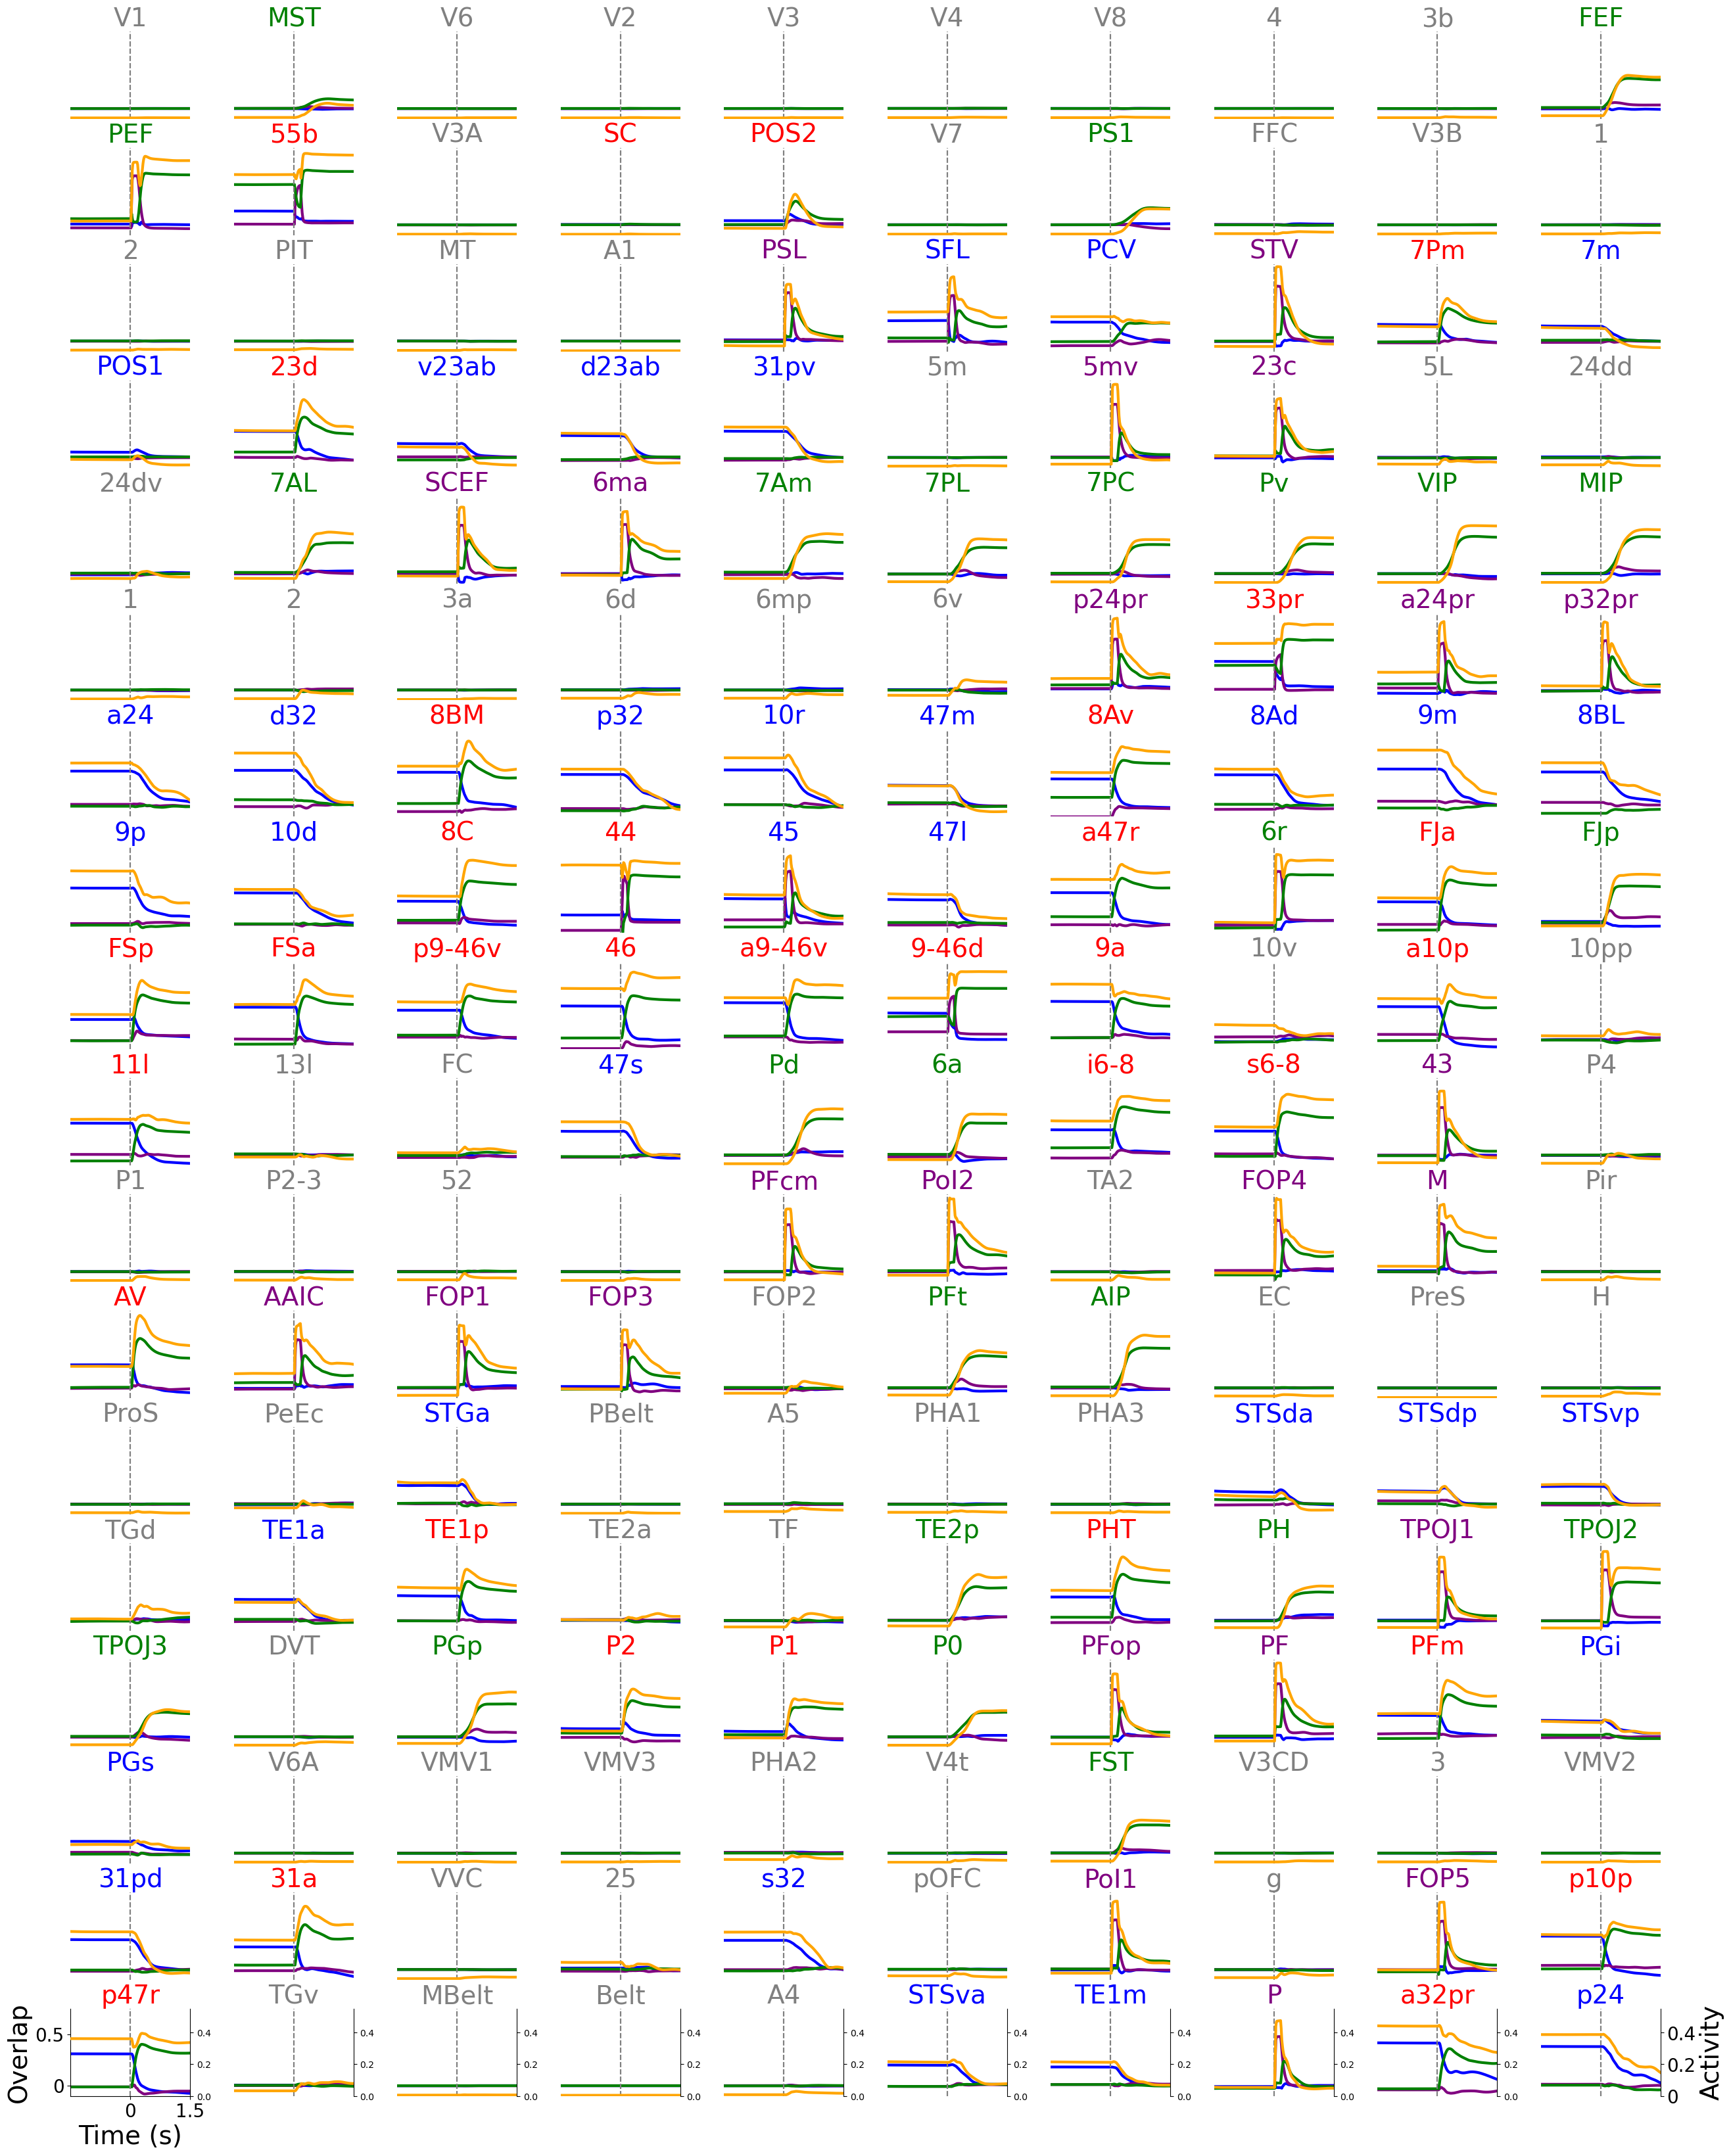

In [8]:

lw_ov = 3
lw_fr = 3
ov_color = 'blue'
m_fr_color = 'orange'
s_ticks = 20
fs=28

modelparams = model_parameters()

#results = pickle.load(open('data/gradient_chaos/sim_0.011.p', 'rb'))
time = results['time']
r_ctx = results['rates_ctx']
overlaps = results['overlaps_sym']
#overlaps_choice = results['overlaps_choice']
overlaps_rand = results['overlaps_random']

name_grad = 'figures/SI_attractors_overlaps_fig_6_human.pdf'






N_block = modelparams['N_block']
p = overlaps.shape[2]
colors = plt.cm.hsv(np.linspace(0,1,N_block))
#names_ctx, inds_full = names_inds_ctx()
modelparams['period'] = 10.
modelparams['t_start']=5.#3.5
modelparams['t_stim']= .15
dt = modelparams['dt']
t_start = modelparams['t_start'] 
t_end = overlaps.shape[0] * dt
t_stop = modelparams['period']
time = np.linspace(0, t_end , overlaps.shape[0])
colors = ['b', 'r']
fig, ax = plt.subplots(figsize=(25, 32),nrows=18, ncols=10)
fig.tight_layout()
l=0
n_row= 0
for row in ax:
    n_col=0
    for col in row:
        col.axvline(x=t_start, ymin=0, ymax=200, ls = '--',color='gray')
        if l<=179:
                 #for s in range(p):
            if l in FPN:
                color = 'red'
            elif l in DMN:
                color = 'blue'
            elif l in DAN:
                color = 'green'
            elif l in salience:
                color = 'purple'
            else:
                color = 'grey'
            col.plot(time, overlaps[:, l, 0, 0], lw =lw_ov, color = 'b')
            col.plot(time, overlaps[:, l, 1, 0], lw =lw_ov, color = 'purple')
            col.plot(time, overlaps[:, l, 1, 1], lw =lw_ov, color = 'g')
            col.set_title((areas['Row'][l].strip("L_")).strip("_ROI"),fontsize = fs, color=color)
            axij = col.twinx()
            r_mean = np.mean(r_ctx[:, l * N_neu: (l + 1)* N_neu], axis = 1)
            axij.plot(time,  r_mean, color = m_fr_color, lw= lw_ov)
            axij.set_ylim([0,.55])
        col.set_xlim([t_start - 1.5, t_start + 1.5])
        col.set_ylim([-.1, .75])
        col.axvline(x=t_start, ymin=0, ymax=200, ls = '--',color='gray')
        if n_col!=0:
            col.set_yticks([])
            col.set_xticks([])
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
            col.spines['bottom'].set_visible(False)
        if n_row!=17:
            col.set_xticks([])
            col.set_yticks([])
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
            col.spines['bottom'].set_visible(False)
            axij.set_xticks([])
            axij.set_yticks([])
            axij.spines['right'].set_visible(False)
            axij.spines['top'].set_visible(False)
            axij.spines['left'].set_visible(False)
            axij.spines['bottom'].set_visible(False)
        if n_col==0 and n_row==17:
            col.set_ylabel('Overlap', fontsize =fs)
            col.set_yticks([0, 0.5])
            col.set_yticklabels([0, 0.5], fontsize = s_ticks)
            col.set_xlabel('Time (s)', fontsize = fs)
            col.set_xticks([t_start, t_start + 1.5])
            col.set_xticklabels([0, 1.5], fontsize = s_ticks)
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
        if n_col==9 and n_row==17:
            axij.set_yticks([0, 0.2, 0.4])
            axij.set_yticklabels([0, 0.2, 0.4], fontsize = s_ticks)
            axij.set_ylabel('Activity', fontsize =fs)
            col.set_yticks([])
            col.set_xticks([])
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
            col.spines['bottom'].set_visible(False)
            col.spines['right'].set_visible(False)
        if n_col != 18:
            #axij.spines['right'].set_visible(False)
            axij.spines['top'].set_visible(False)
            axij.spines['left'].set_visible(False)
            axij.spines['bottom'].set_visible(False)
           # axij.set_yticks([])
        l+=1
        n_col+=1
    n_row+=1
#plt.savefig(str_ov, bbox_inches='tight')
#plt.close()
plt.savefig(name_grad, bbox_inches='tight')

5.0


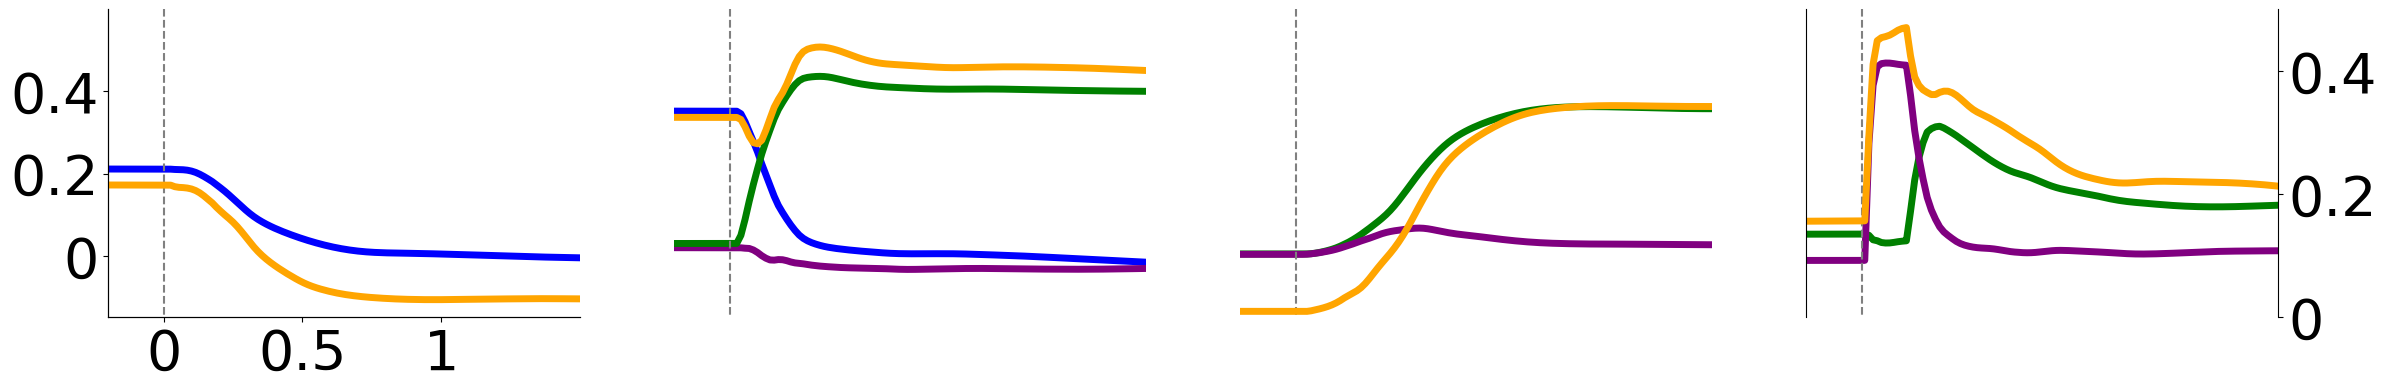

In [9]:
#hereee
names_ctx = [areas['Row'][l].strip("L_").strip("_ROI") for l in range(180)]
time = results['time']
r_ctx = results['rates_ctx']
overlaps = results['overlaps_sym']


ov_color = 'blue'
m_fr_color = 'orange'
s_ticks = 40
lw_fr = 5
lw_ov = 5

dt = modelparams['dt']
modelparams['period'] = 10.
modelparams['t_start']=5.#3.5
modelparams['t_stim']= .15
t_start = modelparams['t_start']
print(t_start)
t_stop = t_start + 1.5
#ind_end = int(t_stop/dt)

t_end = t_stop
deltat = .2 

fig, ax = plt.subplots(figsize=(28, 4),nrows=1, ncols=4)

dN = 10
#frist column
ind1 = names_ctx.index('d23ab')
#for k in range(overlaps.shape[3]):
ax[0].plot(time, overlaps[:, ind1, 0, 0], color = 'b', lw= lw_ov)
#ax[0].plot(time, overlaps[:, ind1, 1, :], color = 'b', lw= lw_ov)
ax[0].set_ylim([-.15,0.6])
ax[0].set_xlim([t_end - 2, t_end])
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_xlim([t_start-deltat, t_end])
ax[0].set_xticks([t_start, t_start+0.5, t_start+1])
ax[0].set_xticklabels([ 0,  0.5, 1], fontsize = s_ticks)
ax[0].set_yticks([0, 0.2, 0.4])
ax[0].set_yticklabels([0, 0.2, 0.4], fontsize = s_ticks)
ax[0].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')

ax10 = ax[0].twinx()
r_mean1 = np.mean(r_ctx[:, ind1* N_neu: (ind1+1)* N_neu], axis = 1)
ax10.plot(time,  r_mean1, color = m_fr_color, lw= lw_ov)
ax10.set_ylim([0,0.5])
ax10.set_xlim([t_start-deltat, t_end])
ax10.set_xticks([t_start, t_start+0.5, t_start+1])
ax10.set_xticklabels([0,  0.5, 1], fontsize = s_ticks)
ax10.spines['right'].set_visible(False)
ax10.spines['top'].set_visible(False)
ax10.set_yticks([])



#second column

ind3 =  names_ctx.index('a9-46v')#

ax[1].plot(time, overlaps[:, ind3, 0, 0], color = 'b', lw= lw_ov)
ax[1].plot(time, overlaps[:, ind3, 1, 0], color = 'purple', lw= lw_ov)
ax[1].plot(time, overlaps[:, ind3, 1, 1], color = 'g', lw= lw_ov)
ax[1].set_ylim([-.15,0.6])
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].set_yticks([])
ax[1].set_xlim([t_start-deltat, t_end])
ax[1].set_xticks([])
#ax[1,2].set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax[1,2].set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax[1].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')

ax12 = ax[1].twinx()
r_mean = np.mean(r_ctx[:, ind3* N_neu: (ind3+1)* N_neu], axis = 1)
ax12.plot(time,  r_mean, color = m_fr_color, lw= lw_ov)
ax12.set_ylim([0,.5])
ax12.set_xlim([t_start-deltat, t_end])
ax12.set_xticks([])
#ax12.set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax12.set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
#ax12.spines['right'].set_visible(False)
ax12.spines['top'].set_visible(False)
ax12.spines['left'].set_visible(False)
ax12.spines['right'].set_visible(False)
ax12.spines['bottom'].set_visible(False)
ax12.set_yticks([])
#ax12.set_yticklabels([0, 0.2, 0.4], fontsize = s_ticks)

#6th column
ind6 = names_ctx.index('MIP')

#ax[2].plot(time, overlaps[:, ind6, 0, 0], color = 'r', lw= lw_ov)
ax[2].plot(time, overlaps[:, ind6, 1, 1], color = 'g', lw= lw_ov)
ax[2].plot(time, overlaps[:, ind6, 1, 0], color = 'purple', lw= lw_ov)
ax[2].set_ylim([-.15,0.6])
ax[2].set_xlim([t_end - 2, t_end])
ax[2].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].spines['left'].set_visible(False)
ax[2].spines['bottom'].set_visible(False)
ax[2].set_yticks([])
ax[2].set_xlim([t_start-deltat, t_end])
ax[2].set_xticks([])
#ax[1,5].set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax[1,5].set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax[2].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
#ax[1,5].axhline(y=0, xmin=0, xmax=400, ls = '--',color='gray')

ax15 = ax[2].twinx()
r_mean = np.mean(r_ctx[:, ind6 * N_neu: (ind6 + 1)* N_neu], axis = 1)
ax15.plot(time,  r_mean, color = m_fr_color, lw= lw_ov)
ax15.set_ylim([0,.5])
ax15.set_xlim([t_start-deltat, t_end])
ax15.set_xticks([])
#ax15.set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax15.set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
#ax12.spines['right'].set_visible(False)
ax15.spines['top'].set_visible(False)
ax15.spines['left'].set_visible(False)
ax15.spines['right'].set_visible(False)
ax15.spines['bottom'].set_visible(False)
ax15.set_yticks([])


#6th column
ind6 = names_ctx.index('AAIC')

#ax[3].plot(time, overlaps[:, ind6, 0, 0], color = 'r', lw= lw_ov)
ax[3].plot(time, overlaps[:, ind6, 1, 1], color = 'g', lw= lw_ov)
ax[3].plot(time, overlaps[:, ind6, 1, 0], color = 'purple', lw= lw_ov)
ax[3].set_ylim([-.15,0.6])
ax[3].set_xlim([t_end - 2, t_end])
ax[3].spines['right'].set_visible(False)
ax[3].spines['top'].set_visible(False)
ax[3].spines['left'].set_visible(False)
ax[3].spines['bottom'].set_visible(False)
ax[3].set_yticks([])
ax[3].set_xlim([t_start-deltat, t_end])
ax[3].set_xticks([])
#ax[1,5].set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax[1,5].set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
ax[3].axvline(x=t_start, ymin=-1, ymax=1, ls = '--',color='gray')
#ax[1,5].axhline(y=0, xmin=0, xmax=400, ls = '--',color='gray')

ax15 = ax[3].twinx()
r_mean = np.mean(r_ctx[:, ind6 * N_neu: (ind6 + 1)* N_neu], axis = 1)
ax15.plot(time,  r_mean, color = m_fr_color, lw= lw_ov)
ax15.set_ylim([0,.5])
ax15.set_xlim([t_start-deltat, t_end])
ax15.set_xticks([])
#ax15.set_xticks([t_start-.5, t_start, t_start+0.5, t_start+1])
#ax15.set_xticklabels([-0.5, 0,  0.5, 1], fontsize = s_ticks)
#ax12.spines['right'].set_visible(False)
ax15.spines['top'].set_visible(False)
#ax15.spines['left'].set_visible(False)
ax15.spines['bottom'].set_visible(False)
ax15.set_yticks([0, 0.2, 0.4])
ax15.set_yticklabels([0, 0.2, 0.4], fontsize = s_ticks)


plt.savefig('figures/panels/salience_fpn_dan_dmn.pdf', bbox_inches='tight')


In [51]:

ind_1 = int((t_end-2)/dt)
ind_2 = int((t_end)/dt)
#saving results for display at the surface
if True:
    #save as mat file
    overlaps_dmn = results['overlaps_sym'][ind_1:ind_2,:,0,0]
    overlaps_dan_1 = results['overlaps_sym'][ind_1:ind_2,:,1,0]
    overlaps_dan_2 = results['overlaps_sym'][ind_1:ind_2,:,1,1]
    ovs = {'overlaps_DMN':overlaps_dmn,
            'overlaps_DAN_1':overlaps_dan_1,
            'overlaps_DAN_2':overlaps_dan_2}
    sio.savemat('results/overlaps_salience_fpn_dan_dmn.mat', ovs)
    r_ctx = results['rates_ctx']
    N_block = modelparams['N_block'] # resolution saved nurons 
    N_recorded = modelparams['N_recorded'] # resolution saved nurons 
    N_neu =int( N_block/int(N_block/N_recorded)) #number recorded neurons
    mean_rates = []
    for l in range(180):
        r_mean = np.mean(r_ctx[ind_1:ind_2, l * N_neu: (l + 1)* N_neu], axis = 1)
        mean_rates.append(r_mean)
    mean_rates = np.array(mean_rates)
    sio.savemat('results/mean_rate_salience_fpn_dan_dmn.mat', {'mean_rates':mean_rates})


In [50]:
mean_rates.shape

(180, 133)

In [47]:
print(20 * dt, 80 * dt)

0.3 1.2


In [42]:
overlaps_dmn.shape

(667, 180)